In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from IPython.display import clear_output
from time import sleep
from pylab import rcParams


%matplotlib inline
%load_ext autoreload
%autoreload 2

rcParams['figure.figsize'] = 10, 20

In [2]:
from games.players.bot import BotPlayer

In [3]:
from env.env_2players_naive_torus import NaiveSandbox

In [4]:
from loss.losses import sum_loss_l1
from model.a2c import ActorCritic

In [5]:
def render(perception_field, env_state, render_agent=False):
    clear_output(wait=True)
    if render_agent:
        plt.imshow(perception_field)
        plt.show()
    #print('field after agent inference')
    plt.imshow(env_state['grid'])
    plt.show()

In [6]:
import torch
import torch.optim as optim

In [7]:
from reward.rewards import AliveCellsReward, MultipleAgentsCellsReward, MultipleAgentsCellsRewardWithEnemyDiscount
reward_fn = MultipleAgentsCellsRewardWithEnemyDiscount()

In [8]:
def merge_agents(first_values,second_values):
    if all([first_values, second_values]):
        return 0
    return second_values if first_values == 0 else first_values
merge_agents = np.vectorize(merge_agents)

def merge_perceptions(old, new):
    return new if old == 0 else old
merge_perceptions = np.vectorize(merge_perceptions)

In [9]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def flatten_grid(grid):
    return torch.tensor(grid).float().flatten().to(DEVICE)

def unsqueeze_grid(grid):
    return torch.FloatTensor(grid).unsqueeze(0).unsqueeze(0).to(DEVICE)

def unsqueeze_states(states):
    return torch.FloatTensor(states).view(-1, GRID, GRID).unsqueeze(1).to(DEVICE)

In [10]:
from time import sleep
def play_game(iterations, state, render_env=True, fall_asleep=False):
    for i in range(iterations):
        perception_1, actions_1 = agent_1.step(flatten_grid(sandbox.get_grid()))
        perception_2, actions_2 = agent_2.step(flatten_grid(sandbox.get_grid()))
        
        perception_field = merge_agents(perception_1, perception_2)
        perception_field = merge_perceptions(sandbox.get_grid(), perception_field)
        
        sandbox.insert_block(perception_field, 0, 0)
        
        reward_signal_weight = 0.1
        
        for s in range(steps_after_action):
            if render_env:
                render(perception_1, {'grid':sandbox.get_grid()})
            if fall_asleep:
                sleep(1.5)
            sandbox.step()

            rewards = reward_fn(sandbox.get_grid())
            env_state = {"grid": sandbox.get_grid(), "rewards":  rewards, "done": sandbox.is_done()}

            if render_env:
                render(perception_1, env_state)
            next_state, reward, done = env_state['grid'], env_state['rewards'], env_state['done']

            states.append(state.flatten());dones.append(done);
            
            intristic_reward = rnd.get_intristic_reward(unsqueeze_grid(state))
            
            total_reward_1 = intristic_reward.detach() + torch.tensor(reward[0]) * reward_signal_weight
            total_reward_2 = intristic_reward.detach() + torch.tensor(reward[1]) * reward_signal_weight
            
            rewards1.append(total_reward_1)
            rewards2.append(total_reward_2)
            actions1.append(actions_1) 
            actions2.append(actions_2)
            
            reward_signal_weight += 0.1
            state = next_state
            if fall_asleep: sleep(0.5)
        if fall_asleep:
            print ("Agents step NOW")
            sleep(0.5)
    print (np.mean(rewards1), np.mean(rewards2))

In [11]:
def reflect_agent(agent, optimizer, states, actions, rewards, dones, list_loss):
    rnd_optimizer.zero_grad()
    optimizer.zero_grad()
    
    intristic_reward = rnd.get_intristic_reward(unsqueeze_states(states))
    
    intristic_reward.backward()
    rnd_optimizer.step()
    
    total_loss = agent.reflect(states, actions, rewards, dones)
    if np.isnan(total_loss.item()):
        return
    
    total_loss.backward()
    
    list_loss.append(total_loss.item())
    torch.nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
    optimizer.step()

In [12]:
x0, y0 = 0, 0
iterations = 100
steps_after_action = 10
N_GAMES = 100
N_CELLS = 10
GRID = 20
LR = 0.001

grid_size=(GRID,GRID)
sandbox = NaiveSandbox(grid_size=grid_size)
state = sandbox.get_grid()

In [13]:
from reward.curiosity_reward import RNDModel

In [18]:
agent_1 = BotPlayer(sandbox, marker=1, max_points_per_step=9, perception_field_size=(4, 4), hard_x_y=(0, 0))
agent_2 = BotPlayer(sandbox, marker=2, max_points_per_step=9, perception_field_size=(4, 4))


rnd = RNDModel(GRID).to(DEVICE)
rnd_optimizer = optim.Adam(rnd.parameters())

optimizer_1 = optim.Adam(agent_1.parameters(), lr=LR)
optimizer_2 = optim.Adam(agent_2.parameters(), lr=LR)

In [19]:
def save(agent, epoch):
    torch.save(agent.state_dict(), './snapshots/agent_{}.pth'.format(epoch))

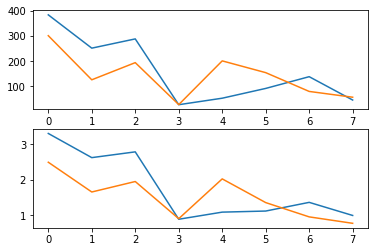

In [ ]:
list_loss1, list_loss2 = [], []
reward_list1, reward_list2 = [], []
for game in range(N_GAMES):
    
    grid_size=(GRID,GRID)
    sandbox = NaiveSandbox(grid_size=grid_size)
    state = sandbox.get_grid()
    
    states, actions1, actions2, rewards1, rewards2, dones = [], [], [], [], [], []
    
    play_game(iterations, state, render_env=False)
    reflect_agent(agent_1, optimizer_1, states, actions1, rewards1, dones, list_loss1)
    reflect_agent(agent_2, optimizer_2, states, actions2, rewards2, dones, list_loss2)
    clear_output(wait=True)
    
    reward_list1.append(np.mean(rewards1))
    reward_list2.append(np.mean(rewards2))
    
    if game % 10 == 0:
        save(agent_1, epoch=game)
    plt.subplot(2, 1, 1)
    plt.plot(list(range(len(list_loss1))), list_loss1)
    plt.plot(list(range(len(list_loss2))), list_loss2)
    
    plt.subplot(2, 1, 2)
    plt.plot(list(range(len(reward_list1))), reward_list1)
    plt.plot(list(range(len(reward_list2))), reward_list2)
    
    plt.show()

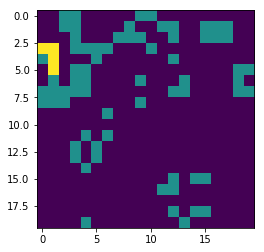

KeyboardInterrupt: 

In [17]:
grid_size=(GRID,GRID)
sandbox = NaiveSandbox(grid_size=grid_size)
state = sandbox.get_grid()
from time import sleep
states, actions, rewards, dones = [], [], [], []
play_game(30, state, fall_asleep=True)

In [36]:
dead_cells, first_player, second_player = np.array([12, 9, 3])

In [37]:
first_player * (first_player - second_player) / dead_cells

4.5

In [38]:
second_player * (second_player - first_player) / dead_cells

-1.5